In [1]:
import os

from IPython.display import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from models import TwoLayerNet
from utils import letter_to_mask, visualize_weights, visualize_weights_distribution, draw_learning_curves, create_gif_from_folder

# Load MNIST Dataset

In [2]:
train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True,
    transform=transforms.ToTensor()
)
test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    transform=transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=128, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=128, 
    shuffle=False
)

# Create model

In [3]:
mask = letter_to_mask('a', 128)

In [4]:
fully_connected = TwoLayerNet(28*28, 128, 10)

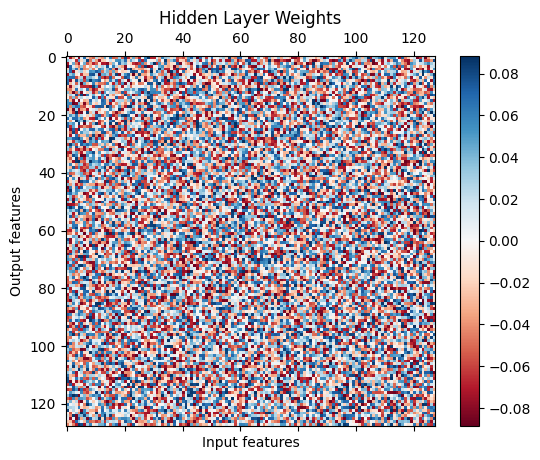

In [5]:
fig = visualize_weights(fully_connected.fc_hidden.weight.data.clone().detach().numpy(), title="Hidden Layer Weights")

In [6]:
fully_connected.mask_hidden_parameters(mask)

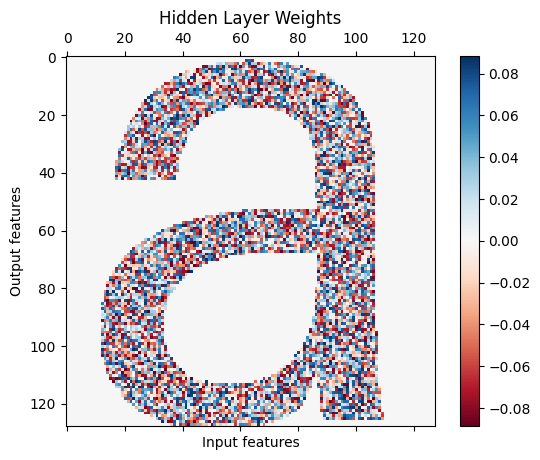

In [7]:
fig = visualize_weights(fully_connected.fc_hidden.weight.data.clone().detach().numpy(), title="Hidden Layer Weights")

# Visualize weights with mask

In [8]:
# Let's use hyperparameters from the paper
hidden_size = 256
fully_connected = TwoLayerNet(28*28, hidden_size, 10)
mask = letter_to_mask('a', hidden_size)
fully_connected.mask_hidden_parameters(mask)

loss = nn.CrossEntropyLoss()
batch_size = 128
optimizer = optim.SGD(fully_connected.parameters(), lr=0.1)
n_epochs = 100

In [9]:
hidden_weights = [fully_connected.fc_hidden.weight.data.clone().detach().numpy()]

train_loss = []
test_loss = []

for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = fully_connected(data)
        l = loss(output, target)
        l.backward()
        optimizer.step()
        epoch_loss += l.item()
    
    epoch_loss /= len(train_loader)
    train_loss.append(epoch_loss)
    
    with torch.no_grad():
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.view(data.size(0), -1)
            output = fully_connected(data)
            l = loss(output, target)
            epoch_loss += l.item()
            
    epoch_loss /= len(test_loader)
    test_loss.append(epoch_loss)
        
    hidden_weights.append(fully_connected.fc_hidden.weight.data.clone().detach().numpy())

100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


In [10]:
fig_dir = 'figures'
os.makedirs(fig_dir, exist_ok=True)

fig_paths = []

v_min = np.min(hidden_weights)
v_max = np.max(hidden_weights)

min_loss = min(min(train_loss), min(test_loss))
max_loss = max(max(train_loss), max(test_loss))

for epoch, weights in enumerate(hidden_weights):
    fig, axs = plt.subplots(nrows=2,
                            ncols=1,
                            figsize=(6, 10)
                            #gridspec_kw={'height_ratios': [2, 1]}
                            )
    
    visualize_weights(weights=weights,
                      title=f"Hidden Layer Weights - Epoch {epoch}",
                      vmin=v_min,
                      vmax=v_max,
                      fig=fig,
                      ax=axs[0])
    
    draw_learning_curves(train_losses=train_loss[:epoch+1],
                         val_losses=test_loss[:epoch+1],
                         min_loss=min_loss,
                         max_loss=max_loss,
                         n_epochs=n_epochs,
                         fig=fig,
                         ax=axs[1])
    
    plt.tight_layout()
    
    fig_path = os.path.join(fig_dir, f'epoch_{epoch}.png')
    fig.savefig(fig_path)
    fig_paths.append(fig_path)
    plt.close(fig)

In [11]:
gif_path = 'training.gif'
create_gif_from_folder(fig_dir, gif_path)

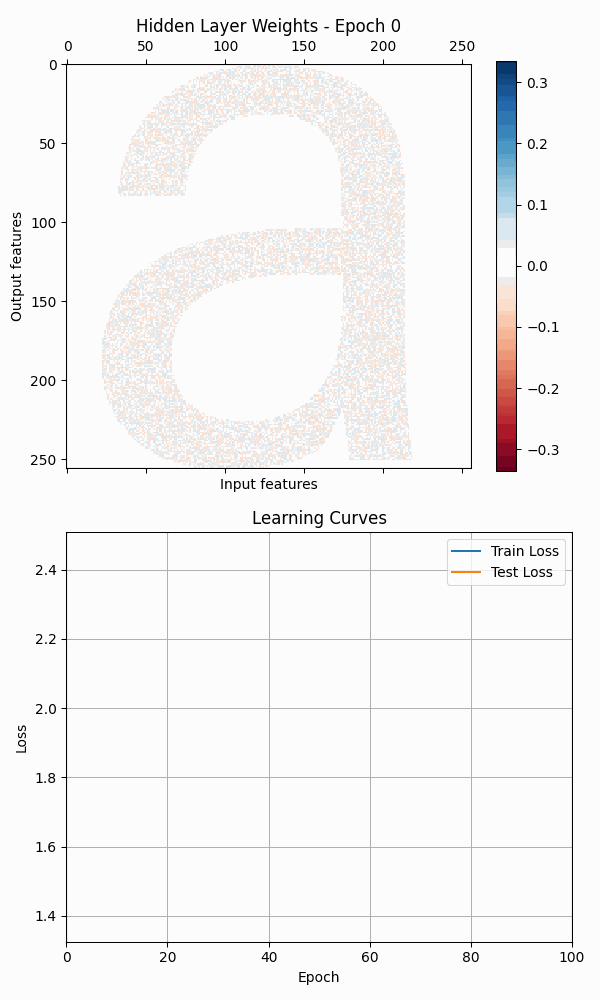

In [12]:
Image(filename=gif_path)

# Visualize weight distribution

In [13]:
# Let's use hyperparameters from the paper
hidden_size = 128
fully_connected = TwoLayerNet(28*28, hidden_size, 10)
# mask = letter_to_mask('a', hidden_size)
# fully_connected.mask_hidden_parameters(mask)

loss = nn.CrossEntropyLoss()
batch_size = 128
optimizer = optim.SGD(fully_connected.parameters(), lr=0.1)
n_epochs = 100

In [14]:
hidden_weights = [fully_connected.fc_hidden.weight.data.clone().detach().numpy()]

train_loss = []
test_loss = []

for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = fully_connected(data)
        l = loss(output, target)
        l.backward()
        optimizer.step()
        epoch_loss += l.item()
    
    epoch_loss /= len(train_loader)
    train_loss.append(epoch_loss)
    
    with torch.no_grad():
        epoch_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.view(data.size(0), -1)
            output = fully_connected(data)
            l = loss(output, target)
            epoch_loss += l.item()
            
    epoch_loss /= len(test_loader)
    test_loss.append(epoch_loss)
        
    hidden_weights.append(fully_connected.fc_hidden.weight.data.clone().detach().numpy())

100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


In [15]:
fig_dir = 'weights'
os.makedirs(fig_dir, exist_ok=True)

fig_paths = []

res = 0.01
x_lim = np.round(np.max(np.abs(hidden_weights[0])), 2)
y_lim = np.round(np.max(np.abs(hidden_weights)), 2)
x_bins = np.round(np.arange(-x_lim, x_lim + res, res), 2)
y_bins = np.round(np.arange(-y_lim, y_lim + res, res), 2)

bin_counts = []
for epoch in range(0, len(hidden_weights)):
    bin_counts.append(
        np.flipud(
            np.histogram2d(x=hidden_weights[0].flatten(),
                           y=hidden_weights[epoch].flatten(),
                           bins=[x_bins, y_bins])[0]).T
    )
    
max_count = np.max(bin_counts)

min_loss = min(min(train_loss), min(test_loss))
max_loss = max(max(train_loss), max(test_loss))

for epoch, counts in enumerate(bin_counts):
    fig, axs = plt.subplots(nrows=2,
                            ncols=1,
                            figsize=(6, 10)
                            #gridspec_kw={'height_ratios': [2, 1]}
                            )
    
    visualize_weights_distribution(weights_counts=counts,
                                   x_bins=x_bins,
                                   y_bins=y_bins,
                                   max_count=max_count,
                                   title=f"Hidden Layer Weights Distribution - Epoch {epoch}",
                                   fig=fig,
                                   ax=axs[0])
    
    draw_learning_curves(train_losses=train_loss[:epoch+1],
                         val_losses=test_loss[:epoch+1],
                         min_loss=min_loss,
                         max_loss=max_loss,
                         n_epochs=n_epochs,
                         fig=fig,
                         ax=axs[1])
    
    plt.tight_layout()
    
    fig_path = os.path.join(fig_dir, f'epoch_{epoch}.png')
    fig.savefig(fig_path)
    fig_paths.append(fig_path)
    plt.close(fig)

In [16]:
gif_path = 'distribution.gif'
create_gif_from_folder(fig_dir, gif_path)

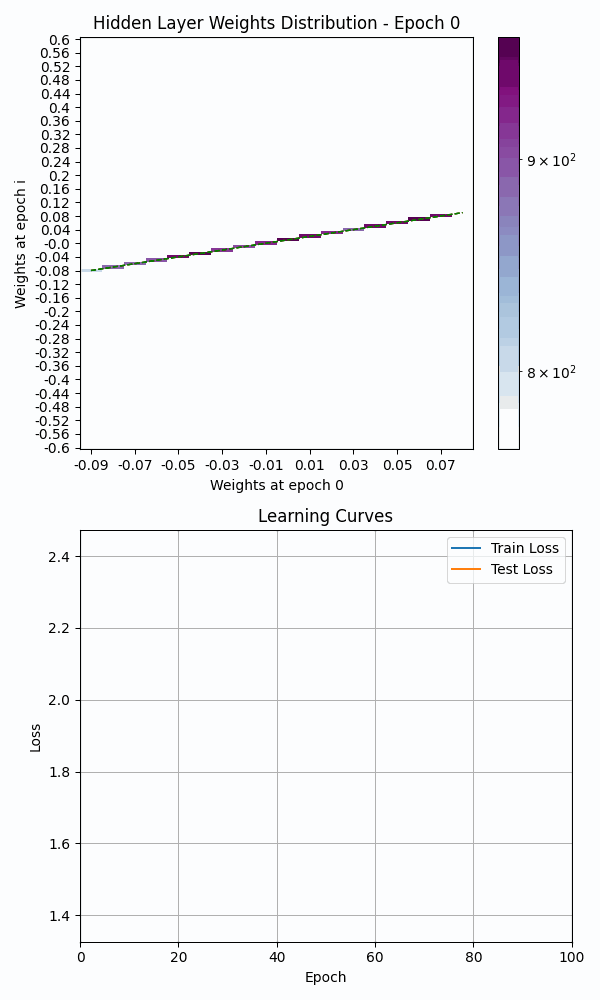

In [17]:
Image(filename=gif_path)